In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from model.MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
eta = 0.0003
epochs = 20000

model = MinAggGNN(2, 8, L, 2, edge_dim = 1)
state_dict = torch.load('model_progress/parallel/model_final.pt')
checkpoints = torch.load('model_progress/parallel/model_checkpoints.pt')
model.load_state_dict(state_dict)
model.eval()
model.to(device)

[autoreload of pyparsing.exceptions failed: Traceback (most recent call last):
  File "c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\IPython\extensions\autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MinAggGNN(2, 2, num_layers=2)

In [5]:
from MINAR.ComputationGraph import ComputationGraph, Circuit
from model.CustomLosses import MultiplicativeLoss, JointLoss
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self.0' : [3, model.convs[0].up_mlp.lins[0].weight[:,-2]],
              'input_self.1' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})
G.number_of_edges()

18432

In [6]:
test_loss = MultiplicativeLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCEWithLogitsLoss()
criterion = JointLoss([mse_loss, bce_loss], [False, True], weight=torch.tensor([1.,25.], device=device))

test_data = torch.load('data/test_data.pt', map_location=device)
test_loader = pyg.loader.DataLoader(test_data, batch_size = len(test_data))
num_reachable_test_nodes = sum([data.reachable.sum() for data in test_loader])
for data in test_data:
    data.x = torch.cat([data.x, data.x_bfs], 1)

corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.x = torch.cat([data_corr.x, data_corr.x_bfs], 1)
    data_corr.x = torch.zeros_like(data_corr.x, device=device)
    data_corr.x[0,0] = 1000.
    data_corr.x[:,1] = torch.ones_like(data_corr.x[:,1], device=device)
    data_corr.x[0,1] = 0.
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

G.calculate_scores(test_data, corrupted_data, criterion, which = 'weight_grad')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP-IG', steps=20)

c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [7]:
# which = 'weight'
# which = 'EAP'
which = 'EAP-IG'
K = 12
C = Circuit(model, G, K=K, key=which)

print(C.number_of_edges())

for data in test_loader:
    out = C.forward(data)
    mul_circuit_loss = float(test_loss(out[:,0][data.reachable].flatten(), data.y[data.reachable]).detach()) / num_reachable_test_nodes
    bfs_accuracy = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
    print(f'Circuit Test Loss: {mul_circuit_loss:.4f}, Test Acc: {bfs_accuracy:.4f}')

25
Circuit Test Loss: 0.0635, Test Acc: 0.9664


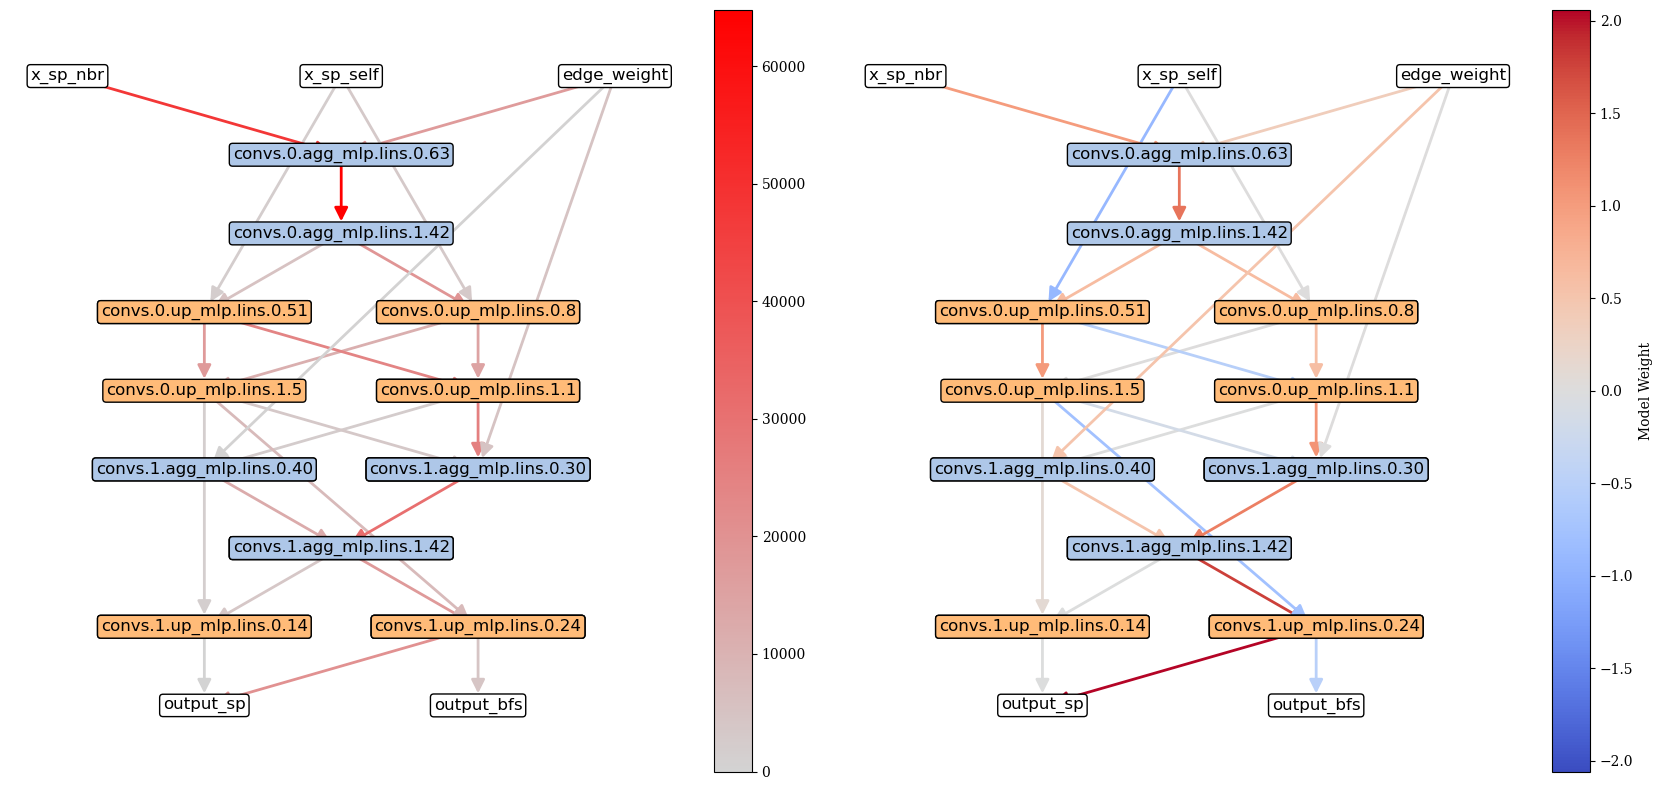

In [82]:
from matplotlib import colors, cm

plt.rcParams['font.family'] = 'serif'
nx.relabel_nodes(C, {C.layers[-1][0] : 'output_sp',
                     C.layers[-1][1] : 'output_bfs',
                     'input.0' : 'x_sp_nbr',
                     'input_self.0' : 'x_sp_self',
                     'edge_attr' : 'edge_weight'}, copy=False)
C.layers[0] = ['x_sp_nbr', 'x_sp_self', 'edge_weight']
C.layers[-1] = ['output_sp', 'output_bfs']

fig, ax = plt.subplots(1, 2, figsize=(17, 8))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}

cvals  = [0, 2]
cs = ["lightgray","red"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), cs))
cmap = colors.LinearSegmentedColormap.from_list("", tuples)

layer_colors = ['white', cm.tab20(1), cm.tab20(1), cm.tab20(3), cm.tab20(3), cm.tab20(1), cm.tab20(1), cm.tab20(3), 'white']

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,which).items())
max_score = max(circuit_edge_scores)
for color, layer in zip(layer_colors, C.layers):
        nx.draw_networkx_labels(C, pos = c_pos, ax=ax[0],
                                labels={node : node for node in layer},
                                bbox=dict(facecolor=color, edgecolor="black", boxstyle="round,pad=0.2")
        )
score_edges = nx.draw_networkx_edges(C, pos = c_pos, ax=ax[0],
        edge_color=circuit_edge_scores,
        width=2,
        arrowsize=20,
        edge_vmin=0,
        edge_vmax=max_score,
        edge_cmap=cmap
)
fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=0, vmax=max_score),
             cmap=cmap),
             ax=ax[0])
ax[0].set_axis_off()

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = abs(max(circuit_edge_weights, key=abs))
for color, layer in zip(layer_colors, C.layers):
        nx.draw_networkx_labels(C, pos = c_pos, ax=ax[1],
                                labels={node : node for node in layer},
                                bbox=dict(facecolor=color, edgecolor="black", boxstyle="round,pad=0.2")
        )
score_edges = nx.draw_networkx_edges(C, pos = c_pos, ax=ax[1],
        edge_color=circuit_edge_weights,
        width=2,
        arrowsize=20,
        edge_vmin=-abs_vmax,
        edge_vmax=abs_vmax,
        edge_cmap=plt.cm.coolwarm
)
fig.colorbar(cm.ScalarMappable(colors.Normalize(vmin=-abs_vmax, vmax=abs_vmax),
             cmap=plt.cm.coolwarm),
             label='Model Weight',
             ax=ax[1])
ax[1].set_axis_off()
plt.tight_layout()
plt.savefig('images/parallel_circuit_nx.png', bbox_inches='tight', dpi=300)

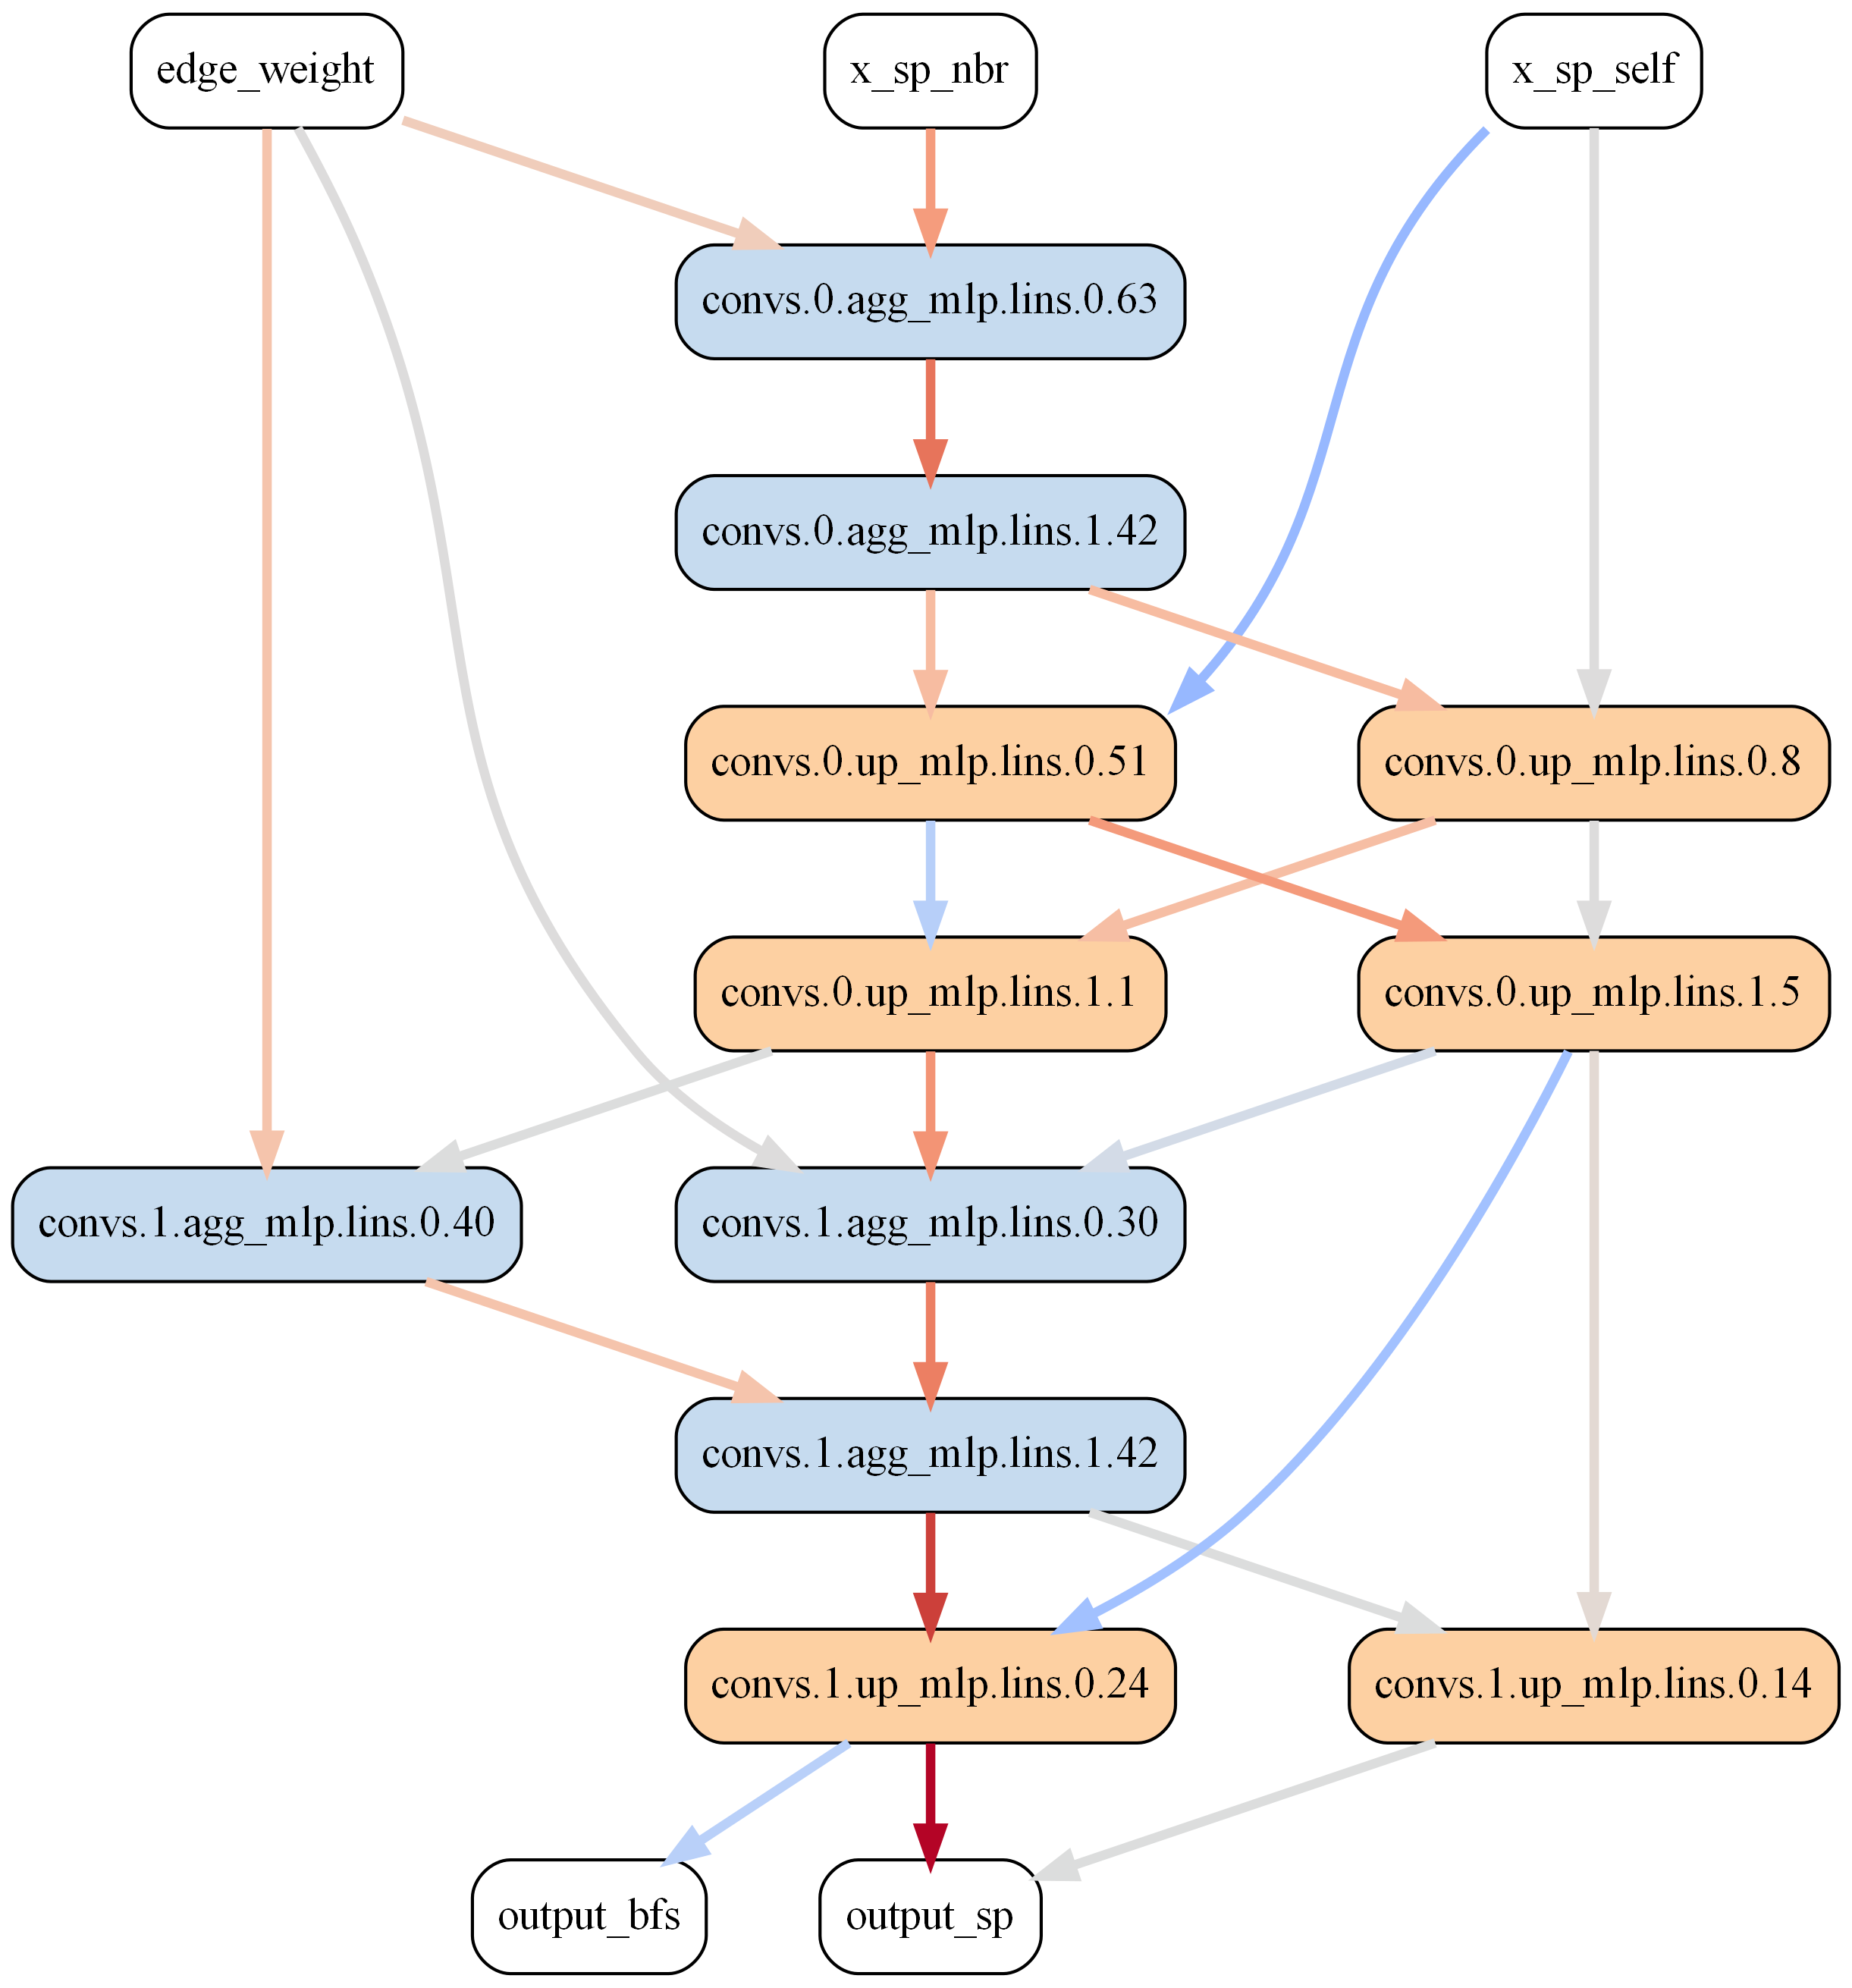

In [79]:
from IPython.display import display
from PIL import Image

C_pydot = nx.nx_agraph.to_agraph(C)
C_pydot.node_attr['shape'] = 'Mrecord'
C_pydot.node_attr['style'] = 'filled'

layer_colors = ['white', '#c6dbef', '#c6dbef', '#fdd0a2', '#fdd0a2', '#c6dbef', '#c6dbef', '#fdd0a2', 'white']
node_colors = {node : layer_colors[layer] for node, layer in nx.get_node_attributes(C, 'layer').items()}
for v in C_pydot.nodes():
    node = C_pydot.get_node(v)
    node.attr['fillcolor'] = node_colors[node]
    node.attr['pos'] = f'{20*c_pos[node][0]},{4*c_pos[node][1]}!'

edge_cmap=plt.cm.coolwarm
_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = abs(max(circuit_edge_weights, key=abs))
normalized_weights = {edge : weight / (2*abs_vmax) + 0.5 for edge, weight in nx.get_edge_attributes(C,'weight').items()}
for u,v in C_pydot.edges():
    edge = C_pydot.get_edge(u,v)
    edge.attr['color'] = colors.to_hex(edge_cmap(normalized_weights[edge]))
    edge.attr["penwidth"] = 3.0

spine = ['x_sp_nbr',
         'convs.0.agg_mlp.lins.0.63',
         'convs.0.agg_mlp.lins.1.42',
         'convs.0.up_mlp.lins.0.51',
         'convs.0.up_mlp.lins.1.1',
         'convs.1.agg_mlp.lins.0.30',
         'convs.1.agg_mlp.lins.1.42',
         'convs.1.up_mlp.lins.0.24',
         'output_sp']
for i in range(len(spine)-1):
    edge = C_pydot.get_edge(spine[i],spine[i+1])
    edge.attr['weight'] = 50

spine2 = ['x_sp_self',
         'convs.0.up_mlp.lins.0.8',
         'convs.0.up_mlp.lins.1.5',
         'convs.1.up_mlp.lins.0.14']
for i in range(len(spine2)-1):
    edge = C_pydot.get_edge(spine2[i],spine2[i+1])
    edge.attr['weight'] = 50

out_edge = C_pydot.get_edge('edge_weight','convs.1.agg_mlp.lins.0.40')
out_edge.attr['weight'] = 50

out_edge2 = C_pydot.get_edge('x_sp_self','convs.0.up_mlp.lins.0.51')
out_edge2.attr['headport']='ne'
out_edge2.attr['tailport']='sw'

inputs = C_pydot.add_subgraph(name='inputs')
inputs.add_nodes_from(C.layers[0])
inputs.graph_attr['rank'] = 'source'

# C_pydot.graph_attr['rankdir']='LR'
C_pydot.graph_attr['nodesep'] = '0.5'
C_pydot.graph_attr['dpi'] = 300
C_pydot.draw("images/parallel_circuit.pdf", prog="dot")
C_pydot.draw("images/parallel_circuit.png", prog="dot")
display(Image.open("images/parallel_circuit.png"))

In [6]:
from tqdm import tqdm
criterion = MultiplicativeLoss()
mse_criterion = torch.nn.MSELoss()
score_methods = ['weight', 'weight_grad', 'EAP', 'EAP-IG']
circuit_test_losses = {score : [] for score in score_methods}
circuit_bfs_accuracy = {score : [] for score in score_methods}
actual_node_count = {score : [] for score in score_methods}
actual_edge_count = {score : [] for score in score_methods}
pbar = tqdm(range(50))
for K in pbar:
    for score in score_methods:
        for data in test_loader:
            C_tmp = Circuit(model, G, K=K, key=score)
            out = C_tmp.forward(data)
            mul_circuit_loss = float(criterion(out[:,0][data.reachable].flatten(), data.y[data.reachable]).detach()) / len(test_data)
            bfs_accuracy = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
            circuit_test_losses[score].append(mul_circuit_loss)
            circuit_bfs_accuracy[score].append(bfs_accuracy)
            actual_node_count[score].append(C_tmp.number_of_nodes())
            actual_edge_count[score].append(C_tmp.number_of_edges())

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
100%|██████████| 50/50 [10:30<00:00, 12.61s/it]


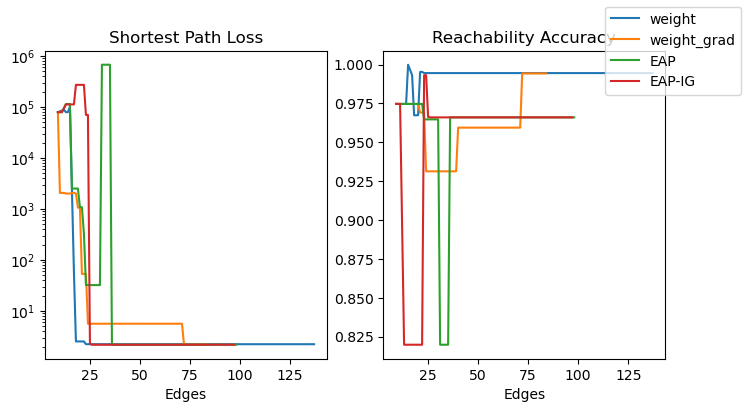

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
for score in score_methods:
    ax[0].plot(actual_edge_count[score], circuit_test_losses[score], label=f'{score}')
ax[0].set_yscale('log')
ax[0].set_title('Shortest Path Loss')
ax[0].set_xlabel('Edges')
for score in score_methods:
    ax[1].plot(actual_edge_count[score], circuit_bfs_accuracy[score])
ax[1].set_title('Reachability Accuracy')
ax[1].set_xlabel('Edges')
plt.xlabel('Edges')
fig.legend()

In [8]:
l1_regs = torch.load('model_progress/parallel/l1_regs.pt')
test_losses = torch.load('model_progress/parallel/test_losses.pt')
test_accs = torch.load('model_progress/parallel/test_accs.pt')

checkpoints = torch.load('model_progress/parallel/model_checkpoints.pt')
circuit_losses = []
circuit_accuracy = []
for checkpoint in checkpoints:
    model.load_state_dict(checkpoint)
    C.model_state_dict = checkpoint
    for data in test_loader:
        out = C.forward(data)
        mul_circuit_loss = criterion(out[:,0][data.reachable].flatten(), data.y[data.reachable]).detach() / num_reachable_test_nodes
        bfs_accuracy = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
        circuit_losses.append(float(mul_circuit_loss))
        circuit_accuracy.append(float(bfs_accuracy))

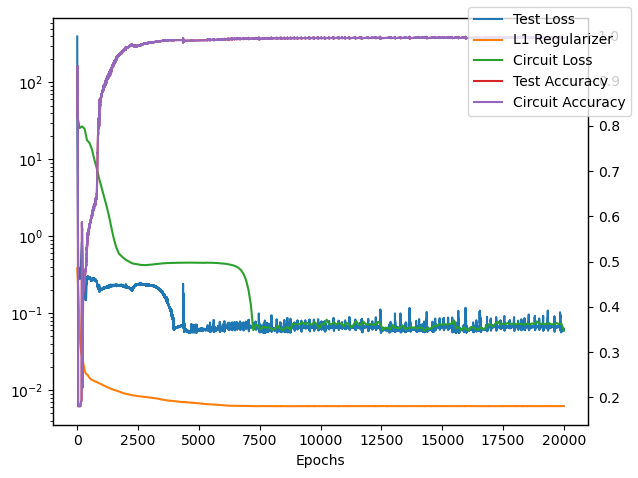

In [9]:
fig, ax = plt.subplots()
ax.plot(test_losses.detach(), label='Test Loss')
ax.plot((eta * l1_regs).detach(), label='L1 Regularizer')

ax2 = ax.twiny()
ax2.plot(circuit_losses, color='tab:green', label='Circuit Loss')

ax3 = ax.twinx()
ax3.plot(test_accs.detach(), color='tab:red', label='Test Accuracy')

ax4 = ax3.twiny()
ax3.plot(test_accs.detach(), color='tab:purple', label='Circuit Accuracy')

ax2.set_xticks([])
ax4.set_xticks([])
ax.set_yscale('log')
ax.set_xlabel('Epochs')

fig.legend()
plt.tight_layout()